# RUNNING SHOES REVIEWS ANALYSIS - Part 2

<div class="alert alert-block alert-info">

# Index | Notebook 2 – Topic Modeling with Sentence-BERT & BERTopic
    
[1. Dataset Overview](#1)<br>

[2. Import Libraries & Load Preprocessed Dataset](#2)<br>

[3. Light Preprocessing](#3)<br>
- [3.1 Review Lenght](#3.1)<br>
- [3.2 Tokenization](#3.2)<br>

[4. Sentence-BERT (Generate Embeddings)](#4)<br>
- [4.1 MiniLM](#4.1)<br>
- [4.2 MPNet](#4.2)<br>

[5. t-SNE & UMAP: Dimensionality Reduction ](#5)<br>

[6. HDBSCAN](#6)<br>

[7. BERTopic: Topic Modeling](#7)<br>

[8. Visualize Topics](#8)<br>

[9. Analyze Topic Distribution](#9)<br>

[13. Hyperparamters Fine-Tuning](#13)

</div>


<a class="anchor" id="2">

# 2. Import Libraries & Load Preprocessed Dataset
    
</a>

In [1]:
# Import libraries

import evaluate
import ftfy
import hdbscan
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import string
import torch
import umap

from bertopic import BERTopic
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from umap import UMAP

In [ ]:
# Import dataset
file_path = "/Users/giuliabovenga/Desktop/Preprocessed Dataset/DF Final Dataset.csv"
df = pd.read_csv(file_path)

In [3]:
# Keep only necessary columns
df = df[['Full_Review', 'sentiment_label', 'Language_review', 'Rating']]

# Drop rows with missing or empty reviews
df = df[df['Full_Review'].notna() & df['Full_Review'].str.strip().ne("")]

In [4]:
# Filter only reviews written in Italian, English and French
df = df[df['Language_review'].isin(['it', 'en', 'fr'])].reset_index(drop=True)

print("Filtered dataset shape:", df.shape)
print("Languages in dataset:\n", df['Language_review'].value_counts())

Filtered dataset shape: (20076, 4)
Languages in dataset:
 Language_review
en    8465
it    5926
fr    5685
Name: count, dtype: int64


In [5]:
df.sample(10)

,Full_Review,sentiment_label,Language_review,Rating
4984,running running femme confortable et légère bo...,Positive,fr,5
12805,super chaussure Aprés 1 mois d'utilisation je ...,Positive,fr,5
15305,Not very comfortable shoes The sole is very ha...,Negative,en,2
15397,Great shoe for the active person! Lots of supp...,Positive,en,5
1793,"Within 3 months, the shoes is cut from top see...",Negative,en,1
18226,Shoes are super comfortable and a great value!...,Positive,en,5
1889,Nice üëç Nice shoes,Positive,en,5
13012,Excellent marathon training shoes Durable and ...,Positive,en,5
4701,Je suis satisfaite de Je suis satisfaite de mo...,Positive,fr,5
17623,"Softer, flashier, faster than ever! I did writ...",Positive,en,5


<a class="anchor" id="3">

# 3. Further Preprocessing
    
</a>

As I am using BERTopic, which is a transformer algorithm, I will perform a light cleaning and I will keep the punctuation as it will be useful later for the tokenization part.

In [6]:
def light_cleaning_bert(text):
    """
    Recommended light cleaning for BERT-based models:
    - fix encoding
    - lowercase
    - removes URLs
    - normalizes spaces
    - leaves punctuation and accents
    """
    text = ftfy.fix_text(str(text))                  # fix UTF encoding
    text = text.lower()                              # lowercase
    text = re.sub(r'http\S+', '', text)              # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra whitespace
    return text


In [7]:
df["Clean_Review"] = df["Full_Review"].apply(light_cleaning_bert)

In [8]:
df["word_count"] = df["Clean_Review"].str.split().apply(len)

In [9]:
# Calculate the length of comments
comment_lengths = df['Clean_Review'].str.len()

I am going to create a multilingual stop word list but I am going to use it in a later step because I will remove these words only in the visualization part but I will keep them during the embeddings

### Stopwords

In [10]:
# create  a multilingual stop word list
stop_words_multilingual = list(set(
    stopwords.words('english') +
    stopwords.words('french') +
    stopwords.words('italian')
))

In [11]:
# Add generic words to exclude (e.g. scarpe, shoes)
custom_generic_words = [
    "scarpa", "scarpe", "chaussures", "chaussure", 
    "shoes", "shoe", "baskets", "basket"
]

# Combine the stopwords
filtered_stopwords = stop_words_multilingual + custom_generic_words

<a class="anchor" id="3.1">

## 3.1 Review Lenght
    
</a>

### Remove short reviews

In [12]:
# Drop short reviews as create noise in the model
df["word_count"] = df["Clean_Review"].str.split().str.len()
df = df[df["word_count"] > 4].reset_index(drop=True)

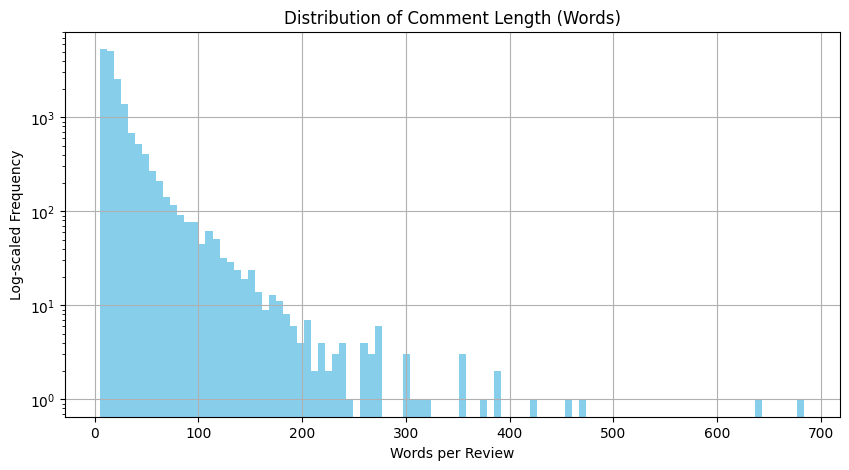

In [13]:
plt.figure(figsize=(10,5))
df["word_count"].hist(bins=100, log=True, color='skyblue')
plt.title("Distribution of Comment Length (Words)")
plt.xlabel("Words per Review")
plt.ylabel("Log-scaled Frequency")
plt.yscale('log')
plt.show()

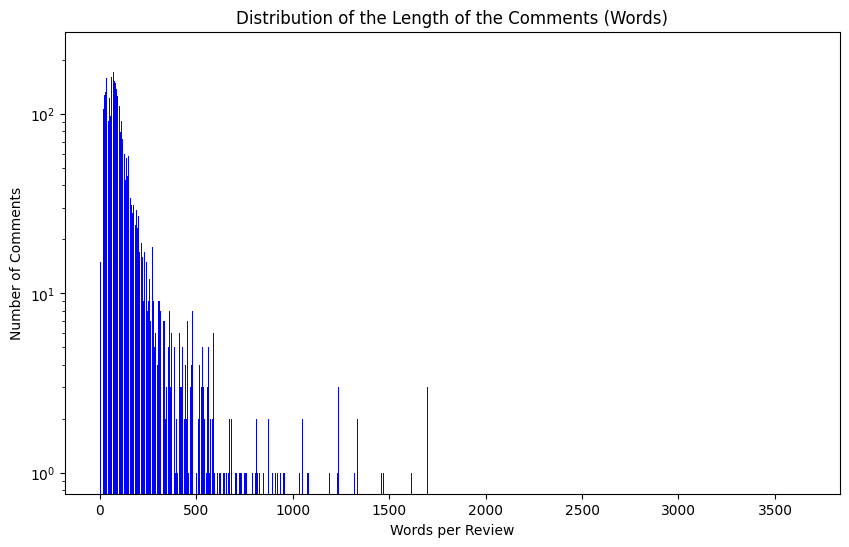

In [14]:
# Calculate the number of comments for each length
comment_length_counts = comment_lengths.value_counts().sort_index()

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(comment_length_counts.index, comment_length_counts.values, color='blue')
plt.xlabel('Words per Review')
plt.ylabel('Number of Comments')
plt.title('Distribution of the Length of the Comments (Words)')
plt.yscale('log')
plt.show()


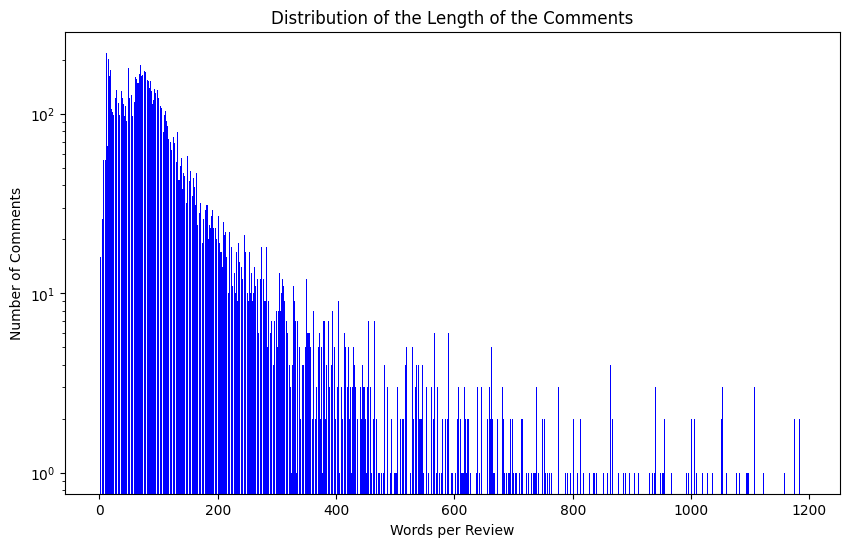

In [15]:
# Exclude reviews longer than 1000 words
comment_lengths_1 = comment_lengths[comment_lengths <= 1200]

# Count number of reviews per comment length
comment_length_counts_1 = comment_lengths_1.value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(comment_length_counts_1.index, comment_length_counts_1.values, color='blue')
plt.xlabel('Words per Review')
plt.ylabel('Number of Comments')
plt.title('Distribution of the Length of the Comments')
plt.yscale('log')
plt.show()


### Remove Length Bias | Maximum Sequence Lenght

The maximum length in tokens manageable by a model (called maximum sequence length) is a key parameter in Transformer models. This maximum length in tokens depends on the configuration of the underlying BERT-like model (MiniLM, DistilBERT, MPNet, etc.). This information can be found in the max_seq_length field of the Hugging Face tokenizer configuration.

The paraphrase-multilingual-MiniLM-L12-v2 model has a maximum length of 256 tokens while distiluse-base-multilingual-cased-v1 and paraphrase-multilingual-mpnet-base-v2 have it of 512 tokens. At the moment I will test these 3 models with a preprocessing that considers 256 tokens maximum length and then eventually I will do more tests for the other two models.

<a class="anchor" id="3.2">

## 3.2 Tokenization
    
</a>

<a class="anchor" id="3.2.1">

### 3.2.1 sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    
</a>

In [16]:
# Load the multilingual Sentence-BERT model MiniLM-L12-v2
model_miniLM = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"


In [17]:
tokenizer_miniLM = AutoTokenizer.from_pretrained(model_miniLM)

In [18]:
max_tokens = 256

def split_into_token_chunks(text, tokenizer, max_tokens=256, min_words=10):
    """
    Breaks text into chunks <= max_tokens (in tokens), joining sentences as long as possible.
    Chunks that are too short are joined to the previous one if possible.
    """
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    
    chunks = []
    current_chunk = ""
    
    for sent in sentences:
        candidate = (current_chunk + " " + sent).strip()
        token_count = len(tokenizer.encode(candidate, truncation=False))

        if token_count <= max_tokens:
            current_chunk = candidate
        else:
            if current_chunk:
                # Before adding, check if it is too short
                if len(current_chunk.split()) < min_words and chunks:
                    # Merge with previous chunk if possible
                    chunks[-1] += " " + current_chunk
                else:
                    chunks.append(current_chunk.strip())
            # Sentence too long by itself -> forcefully cut it out
            tokens = tokenizer.encode(sent, truncation=False)
            for i in range(0, len(tokens), max_tokens):
                sub_chunk = tokenizer.decode(tokens[i:i+max_tokens], skip_special_tokens=True)
                chunks.append(sub_chunk.strip())
            current_chunk = ""
    
    if current_chunk:
        if len(current_chunk.split()) < min_words and chunks:
            chunks[-1] += " " + current_chunk
        else:
            chunks.append(current_chunk.strip())
    
    return chunks

split_rows = []

for idx, row in df.iterrows():
    text = row["Clean_Review"]
    segments = split_into_token_chunks(text, tokenizer=tokenizer_miniLM, max_tokens=256, min_words=10)
    
    for chunk_id, segment in enumerate(segments):
        new_row = row.copy()
        new_row["Clean_Review"] = segment
        new_row["chunk_id"] = chunk_id
        new_row["word_count"] = len(segment.split())
        split_rows.append(new_row)


In [19]:
# New dataframe with split reviews 
df_miniLM = pd.DataFrame(split_rows)
df_miniLM.reset_index(drop=True, inplace=True)

In [ ]:
# Filter again chunk too short
df_miniLM = df_miniLM[df_miniLM["word_count"] >= 10].reset_index(drop=True)

In [21]:
df_miniLM.sample(5)

,Full_Review,sentiment_label,Language_review,Rating,Clean_Review,word_count,chunk_id
12793,Different from PXS v1 But Still Great The firs...,Positive,en,5,i think tts will work fine for most people but...,20,2
6834,Best all around running shoe! Real ones know t...,Positive,en,5,best all around running shoe! real ones know t...,41,0
8718,"they are comfy I like them, I'm using those sh...",Positive,en,5,"they are comfy i like them, i'm using those sh...",14,0
9313,Very comfortable Runs a little bit bigger I co...,Positive,en,5,very comfortable runs a little bit bigger i co...,14,0
2323,Cet article ne convient Cet article ne convien...,Negative,fr,1,cet article ne convient cet article ne convien...,25,0


In [22]:
# Check unique chunks
df_miniLM["chunk_id"].nunique()

7

In [23]:
# check the chunks
df_miniLM["chunk_id"].value_counts().sort_index()


chunk_id
0    13595
1       78
2       56
3       10
4        9
5        2
6        2
Name: count, dtype: int64

In [24]:
# Count how many records there are for every chunk
chunk_counts = df_miniLM["chunk_id"].value_counts()

In [25]:
# Check the chunks with 5 or 6
chunk_ids_5_6 = chunk_counts[chunk_counts.index.isin([5, 6])].index.tolist()
df_miniLM[df_miniLM["chunk_id"].isin(chunk_ids_5_6)]


,Full_Review,sentiment_label,Language_review,Rating,Clean_Review,word_count,chunk_id
10248,Would recommend for trail-running X-country Fi...,Positive,en,4,i do wish they would make the soles perform ju...,31,5
10249,Would recommend for trail-running X-country Fi...,Positive,en,4,the ever so slightly softer sole seems like a ...,107,6
10265,Would recommend for X-country trainers First o...,Positive,en,4,"anyhow, the terrex agravic 3 trail running sho...",65,5
10266,Would recommend for X-country trainers First o...,Positive,en,4,if you're not used to buying adidas running sh...,23,6


<a class="anchor" id="4">

# 4. Sentence-BERT: (Generate Embeddings)
    
</a>

<a class="anchor" id="4.1">

### 4.1 Model sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
    
</a>

`df_miniLM` is the dataset used in this section. 

In this section, I am loading a pretrained model that should be able to work with my crosslingual dataset. It returns a numerical representation of the meaning of each sentence (these numbers are called embeddings).

In [26]:
df_miniLM.shape

(13752, 7)

In [27]:
# Define the input texts for the model 
texts_miniLM = df_miniLM['Clean_Review'].tolist()

# Sentence model
sentence_model_miniLM = SentenceTransformer(model_miniLM)

# Generate embeddings
embeddings_miniLM = sentence_model_miniLM.encode(texts_miniLM, show_progress_bar=True, batch_size=32)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/430 [00:00<?, ?it/s]

In this step, the model is extracting all the textual reviews from Clean_Review and putting them in a list where each review is converted to a numeric vector (embedding).

In [28]:
embeddings_miniLM.shape

(13752, 384)

In [29]:
# CountVectorizer
vectorizer_model = CountVectorizer(stop_words=filtered_stopwords)

In [30]:
# UMAP
umap_model_miniLM = UMAP(n_neighbors=15,
                    n_components=5,
                    min_dist=0.0,
                    metric='cosine')

In [31]:
# HDBSCAN
hdbscan_model_miniLM = HDBSCAN(min_cluster_size=25,
                          min_samples=3,
                          metric='euclidean',
                          cluster_selection_method='eom',
                          prediction_data=True)

In [32]:
topic_model_miniLM = BERTopic(
    embedding_model=sentence_model_miniLM,
    umap_model=umap_model_miniLM,
    hdbscan_model=hdbscan_model_miniLM,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=False,
    verbose=True,
    language="multilingual"
)

In [33]:
reviews_miniLM = df_miniLM["Clean_Review"].dropna().tolist()

In [34]:
topics_miniLM, probs_miniLM = topic_model_miniLM.fit_transform(reviews_miniLM)

2025-05-11 17:58:29,125 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/430 [00:00<?, ?it/s]

2025-05-11 17:58:48,311 - BERTopic - Embedding - Completed ✓
2025-05-11 17:58:48,311 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-05-11 17:58:57,136 - BERTopic - Dimensionality - Completed ✓
2025-05-11 17:58:57,137 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-11 17:58:57,416 - BERTopic - Cluster - Completed ✓
2025-05-11 17:58:57,418 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 17:58:57,562 - BERTopic - Representation - Completed ✓


In [35]:
# Visualize the hierarchical topics
topic_model_miniLM.hierarchical_topics(reviews_miniLM)
topic_model_miniLM.visualize_hierarchy()


100%|██████████| 96/96 [00:00<00:00, 877.76it/s]


In [36]:
topic_model_miniLM.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6119,-1_très_great_running_good,"[très, great, running, good, comfortable, size...",[excellent running shoe the cushion is good an...
1,0,626,0_camminata_camminare_marche_corsa,"[camminata, camminare, marche, corsa, running,...","[molto belle e comode, ottime per camminata e ..."
2,1,585,1_comoda_ottima_leggera_molto,"[comoda, ottima, leggera, molto, buona, prezzo...",[ottimo acquisto ottimo rapporto qualità/prezz...
3,2,374,2_running_great_comfortable_runs,"[running, great, comfortable, runs, training, ...",[stable enough for an overpronator! fab shoe. ...
4,3,261,3_taille_peu_trop_manque,"[taille, peu, trop, manque, semelle, troppo, h...",[bonne chaussure mais taille bonne chaussure m...
...,...,...,...,...,...
93,92,26,92_anno_colori_problema_noire,"[anno, colori, problema, noire, femme, couleur...",[ogni anno compro per il mio lavoro queste sca...
94,93,25,93_next_best_race_ever,"[next, best, race, ever, feeling, legs, unriva...",[my next race shoe i have a ton of shoes - mos...
95,94,25,94_faster_recovery_training_companion,"[faster, recovery, training, companion, runs, ...",[amazing cushioning and propulsion i've now ru...
96,95,25,95_adidas_exchange_order_refund,"[adidas, exchange, order, refund, service, los...",[dont order through adidas directly! i ordered...


In [37]:
topic_model_miniLM.visualize_barchart()

<a class="anchor" id="4.2">

### 4.2  MPNet
    
</a>

In [39]:
# Load MPNet model and tokenizer
model_mpnet = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
tokenizer_mpnet = AutoTokenizer.from_pretrained(model_mpnet)
sentence_model_mpnet = SentenceTransformer(model_mpnet)

In [40]:
# Define max tokens and minimum word threshold
max_tokens = 256
min_words = 10

# Function to split long reviews into token-limited chunks
def split_into_token_chunks(text, tokenizer, max_tokens=256, min_words=10):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    chunks = []
    current_chunk = ""
    for sent in sentences:
        candidate = (current_chunk + " " + sent).strip()
        token_count = len(tokenizer.encode(candidate, truncation=False))
        if token_count <= max_tokens:
            current_chunk = candidate
        else:
            if current_chunk:
                if len(current_chunk.split()) < min_words and chunks:
                    chunks[-1] += " " + current_chunk
                else:
                    chunks.append(current_chunk.strip())
            tokens = tokenizer.encode(sent, truncation=False)
            for i in range(0, len(tokens), max_tokens):
                sub_chunk = tokenizer.decode(tokens[i:i+max_tokens], skip_special_tokens=True)
                chunks.append(sub_chunk.strip())
            current_chunk = ""
    if current_chunk:
        if len(current_chunk.split()) < min_words and chunks:
            chunks[-1] += " " + current_chunk
        else:
            chunks.append(current_chunk.strip())
    return chunks

# Apply chunking to all reviews in the dataframe
split_rows = []
for idx, row in df.iterrows():
    text = row["Clean_Review"]
    segments = split_into_token_chunks(text, tokenizer=tokenizer_mpnet, max_tokens=max_tokens, min_words=min_words)
    for chunk_id, segment in enumerate(segments):
        new_row = row.copy()
        new_row["Clean_Review"] = segment
        new_row["chunk_id"] = chunk_id
        new_row["word_count"] = len(segment.split())
        split_rows.append(new_row)

In [41]:
# Create a new DataFrame from the chunks
df_mpnet = pd.DataFrame(split_rows)
df_mpnet = df_mpnet[df_mpnet["word_count"] >= min_words].reset_index(drop=True)

In [42]:
# Generate embeddings
texts_mpnet = df_mpnet["Clean_Review"].tolist()
embeddings_mpnet = sentence_model_mpnet.encode(texts_mpnet, show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/430 [00:00<?, ?it/s]

In [43]:
vectorizer_model = CountVectorizer(stop_words=filtered_stopwords)

In [44]:
# Define UMAP 
umap_model_mpnet = UMAP(
    n_neighbors=5, 
    n_components=8, 
    min_dist=0.0, 
    metric='cosine')

# HDBSCAN models
hdbscan_model_mpnet = HDBSCAN(
    min_cluster_size=15, 
    min_samples=3, 
    metric='euclidean', 
    prediction_data=True)

# Train BERTopic
topic_model_mpnet = BERTopic(
    embedding_model=sentence_model_mpnet,
    umap_model=umap_model_mpnet,
    hdbscan_model=hdbscan_model_mpnet,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=False,
    verbose=True,
    language="multilingual"
)

In [45]:
topics_mpnet, probs_mpnet = topic_model_mpnet.fit_transform(texts_mpnet, embeddings_mpnet)

2025-05-11 18:00:14,461 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-11 18:00:17,020 - BERTopic - Dimensionality - Completed ✓
2025-05-11 18:00:17,021 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-11 18:00:17,334 - BERTopic - Cluster - Completed ✓
2025-05-11 18:00:17,337 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 18:00:17,542 - BERTopic - Representation - Completed ✓


In [46]:
# View topic summary MPNet
topic_model_mpnet.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4631,-1_great_très_comfortable_good,"[great, très, comfortable, good, super, size, ...",[surprisingly fast for the size and weight i h...
1,0,213,0_running_prezzo_corsa_purchase,"[running, prezzo, corsa, purchase, rapporto, d...",[scarpe da donna jogging leggera e confortevol...
2,1,176,1_color_colors_love_colore,"[color, colors, love, colore, design, looks, c...",[worth to buy nice design & color; very light ...
3,2,158,2_trail_accroche_excellente_bonne,"[trail, accroche, excellente, bonne, terrain, ...",[excellente chaussure de trail excellente chau...
4,3,115,3_trail_montagne_randonnée_utilisé,"[trail, montagne, randonnée, utilisé, forêt, t...","[très bon produit, je très bon produit, je l'a..."
...,...,...,...,...,...
257,256,15,256_runnings_courrir_sûrement_parfaite,"[runnings, courrir, sûrement, parfaite, ras, g...",[super confortables sûrement les runnings supe...
258,257,15,257_podiatrist_175lbs_alien_lol,"[podiatrist, 175lbs, alien, lol, 20s, scambio,...",[alien tech in this shoe helps get through tra...
259,258,15,258_sconto_costano_economica_usare,"[sconto, costano, economica, usare, economiche...","[buoni e costano poco. presi anche in sconto, ..."
260,259,15,259_souples_amorties_absorber_permettant,"[souples, amorties, absorber, permettant, dyna...",[chaussures très souples et chaussures très so...


In [47]:
# Visualize the hierarchical topics
topic_model_mpnet.hierarchical_topics(texts_mpnet)
topic_model_mpnet.visualize_hierarchy()


100%|██████████| 260/260 [00:00<00:00, 813.59it/s]


In [48]:
# ----- Topic Quality Evaluation -----

# Compute silhouette score in UMAP space (optional, if not already computed)
umap_embeddings = topic_model_mpnet.umap_model.transform(embeddings_mpnet)
if len(set(topics_mpnet)) > 1:
    sil_score = silhouette_score(umap_embeddings, topics_mpnet)
else:
    sil_score = np.nan

# Calculate noise percentage (topic -1)
noise_pct = np.mean(np.array(topics_mpnet) == -1)

# Print evaluation summary
print("------ Topic Quality Evaluation ------")
print(f"Number of topics found      : {len(set(topics_mpnet)) - (1 if -1 in topics_mpnet else 0)}")
print(f"Silhouette score (UMAP space): {sil_score:.4f}")
print(f"Percentage of noise (–1 topic): {noise_pct*100:.2f}%\n")

# Print top words per topic (e.g. top 10)
print("Top words per topic:")
for topic_num in sorted(topic_model_mpnet.get_topics().keys()):
    if topic_num is not None:
        top_words = [word for word, _ in topic_model_mpnet.get_topic(topic_num)[:10]]
        print(f"Topic {topic_num}: {top_words}")


------ Topic Quality Evaluation ------
Number of topics found      : 261
Silhouette score (UMAP space): 0.0382
Percentage of noise (–1 topic): 33.68%

Top words per topic:
Topic -1: ['great', 'très', 'comfortable', 'good', 'super', 'size', 'running', 'feet', 'elles', 'run']
Topic 0: ['running', 'prezzo', 'corsa', 'purchase', 'rapporto', 'donna', 'correre', 'qualità', 'price', 'jogging']
Topic 1: ['color', 'colors', 'love', 'colore', 'design', 'looks', 'couleurs', 'colour', 'purchase', 'comfortable']
Topic 2: ['trail', 'accroche', 'excellente', 'bonne', 'terrain', 'boueux', 'hiking', 'trekking', 'grip', 'forêt']
Topic 3: ['trail', 'montagne', 'randonnée', 'utilisé', 'forêt', 'terrain', 'randonnées', 'chemins', 'trails', 'grip']
Topic 4: ['work', 'day', 'giorno', 'giorni', 'everyday', 'utilise', 'jours', 'every', 'comoda', 'ore']
Topic 5: ['suggestion', 'purchase', 'stairs', 'example', 'climbing', 'next', 'london', 'jogging', 'rapporto', 'year']
Topic 6: ['adidas', 'sempre', 'prodotti', 

In [ ]:
stop before hyperparameters tuning

SyntaxError: invalid syntax (3236676662.py, line 1)

<a class="anchor" id="13">

# 13. Hyperparameters Fine-Tuning
    
</a>

## MiniLM-L12-v2

In [ ]:
# Sample from the dataset
subset_df = df_miniLM.sample(3500, random_state=42)
texts_subset = subset_df["Clean_Review"].tolist()

# Embedding model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings_subset = model.encode(texts_subset, show_progress_bar=True, batch_size=32)

# Stopwords
stop_words_multilingual = list(set(
    stopwords.words('english') +
    stopwords.words('french') +
    stopwords.words('italian')
))
vectorizer = CountVectorizer(stop_words=stop_words_multilingual)

# Parameters Grid
param_grid = [
    {"min_cluster_size": mcs, "min_samples": ms, "n_neighbors": nn, "n_components": nc, "umap_metric": um}
    for mcs in [15, 25, 35]
    for ms in [3, 5]
    for nn in [10, 15]
    for nc in [5, 8]
    for um in ["cosine", "manhattan"]
]

results = []

for params in param_grid:
    print(f"Testing: {params}")
    
    umap_model = UMAP(
        n_neighbors=params["n_neighbors"],
        n_components=params["n_components"],
        min_dist=0.1,
        metric=params["umap_metric"]
    )
    
    hdbscan_model = HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        metric="euclidean",
        prediction_data=True
    )
    
    topic_model = BERTopic(
        embedding_model=model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer,
        calculate_probabilities=False,
        language="multilingual",
        verbose=False
    )
    
    topics, _ = topic_model.fit_transform(texts_subset, embeddings_subset)
    n_topics = len(set(topics)) - (1 if -1 in topics else 0)

    # Calculate silhouette score on reduced UMAP embeddings
    umap_embeddings = topic_model.umap_model.transform(embeddings_subset)
    try:
        if len(set(topics)) > 1:
            sil_score = silhouette_score(umap_embeddings, topics)
        else:
            sil_score = np.nan
    except:
        sil_score = np.nan

    # Percentage of unassigned points (noise)
    noise_pct = np.mean(np.array(topics) == -1)

    results.append({
        "min_cluster_size": params["min_cluster_size"],
        "min_samples": params["min_samples"],
        "n_neighbors": params["n_neighbors"],
        "n_components": params["n_components"],
        "umap_metric": params["umap_metric"],
        "hdbscan_metric": "euclidean",
        "num_topics": n_topics,
        "silhouette_score": sil_score,
        "noise_pct": noise_pct
    })

# Convert into a  DataFrame
results_df = pd.DataFrame(results)

Batches:   0%|          | 0/110 [00:00<?, ?it/s]

Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 10, 'n_components': 5, 'umap_metric': 'cosine'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 10, 'n_components': 5, 'umap_metric': 'manhattan'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 10, 'n_components': 8, 'umap_metric': 'cosine'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 10, 'n_components': 8, 'umap_metric': 'manhattan'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 15, 'n_components': 5, 'umap_metric': 'cosine'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 15, 'n_components': 5, 'umap_metric': 'manhattan'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 15, 'n_components': 8, 'umap_metric': 'cosine'}
Testing: {'min_cluster_size': 15, 'min_samples': 3, 'n_neighbors': 15, 'n_components': 8, 'umap_metric': 'manhattan'}
Testing: {'min_cluster_size': 15, 'min_samples': 5, 'n_neighbors': 1

In [ ]:
results_df.sort_values(by=["num_topics", "silhouette_score"], ascending=[False, False]).head(15)


,min_cluster_size,min_samples,n_neighbors,n_components,umap_metric,hdbscan_metric,num_topics,silhouette_score,noise_pct
0,15,3,10,5,cosine,euclidean,51,-0.078824,0.432000
1,15,3,10,5,manhattan,euclidean,51,-0.163074,0.460857
4,15,3,15,5,cosine,euclidean,48,-0.084620,0.426000
6,15,3,15,8,cosine,euclidean,45,-0.082694,0.420571
10,15,5,10,8,cosine,euclidean,42,-0.098383,0.440286
2,15,3,10,8,cosine,euclidean,41,-0.015781,0.323429
7,15,3,15,8,manhattan,euclidean,41,-0.103703,0.411714
5,15,3,15,5,manhattan,euclidean,37,-0.077588,0.392000
12,15,5,15,5,cosine,euclidean,34,-0.037369,0.406571
14,15,5,15,8,cosine,euclidean,34,-0.106703,0.416000


The best combination seems to be the index 8 (row 7) as it has a good balance between number of topics (31) and semantic quality (silhouette > 0.05); moreover, the percentage of noise is low and it is not too oversegmented like top 2 (48-46 topics, lots of noise). Others hood combination could be the index 6 and 56.


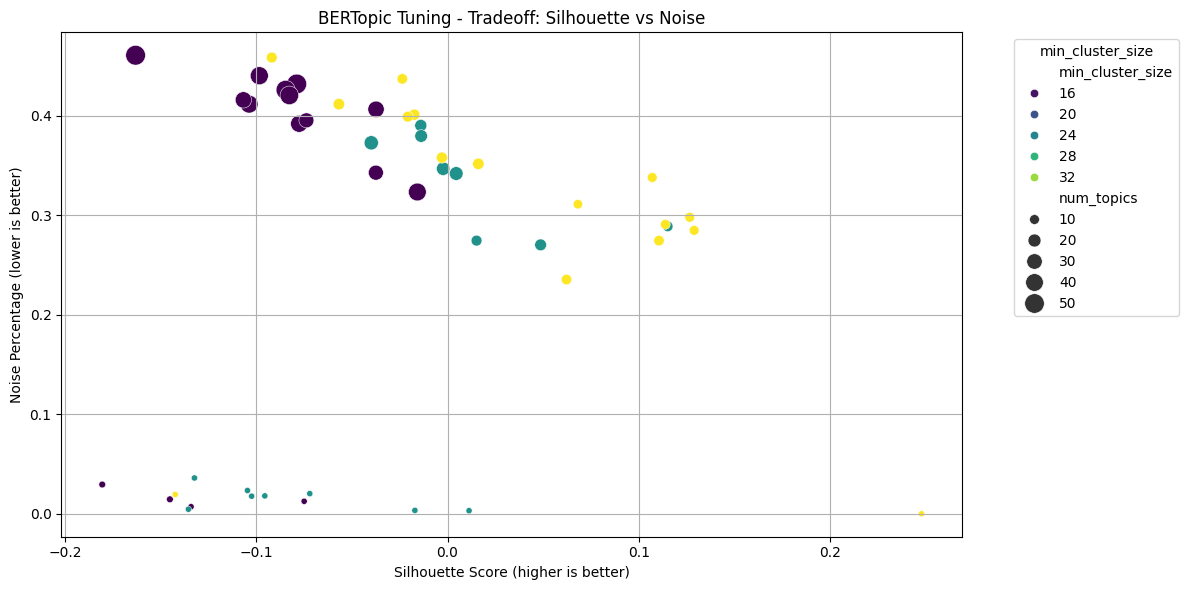

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="silhouette_score",
    y="noise_pct",
    size="num_topics",
    hue="min_cluster_size",
    palette="viridis",
    sizes=(20, 200),
    legend="brief"
)

plt.title("BERTopic Tuning - Tradeoff: Silhouette vs Noise")
plt.xlabel("Silhouette Score (higher is better)")
plt.ylabel("Noise Percentage (lower is better)")
plt.grid(True)
plt.legend(title="min_cluster_size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
